# PROJECT: UNSUPERVISED LEARNING
                                                                        by: Aryan Jain
### <span style="color:blue">March 2021</span>

## <span style="color:orange">SUMMARY</span>

<b>Context:</b>
    The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.
    
<b>Data Description:</b>    
    The data contains features extracted from the silhouette of vehicles in different angles. Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

<b>Attribute Information:</b>
* All the features are geometric features extracted from the silhouette. 
* All are numeric in nature.

<b>Domain:</b>
    Object recognition    
    
<b>Objectives:</b>
    Apply dimensionality reduction technique –PCA and train a model using principle components instead of training the model using just the raw data.
 
<b>Key Tasks:</b>
 - Import & explore the data
 - Data Pre-processing
 - Data analysis & Visualization
 - Model training, testing & tuning
 - Compare the accuracy scores and cross validation scores of Support vector machines –one trained using raw data and the other using Principal Components
 
<b>Learning Objectives:</b>
* Exploratory Data Analysis
* Reduce the number of dimensions in a dataset with minimal information loss
* Train a model using Principal Components

## <span style="color:purple"> Importing the necessary libraries

In [1]:
# import libraries

# Data Management and Vizualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Models
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Model Building
from sklearn.model_selection import train_test_split

# Normalization
from scipy.stats import zscore

# Scoring
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Others
import warnings
warnings.filterwarnings("ignore")

# display all columns
pd.options.display.max_columns = None

### <span style="color:green">Creating functions to gather and display model performance measures</span>

## <span style="color:purple"> Functions

In [2]:
def update_performance_summary(perf_summary_df, model_name, train_acc, test_acc, cv_acc):
    perf_summary_df.loc[len(perf_summary_df.index)] = [model_name, train_acc, test_acc, cv_acc]
    return perf_summary_df

In [3]:
def get_model_performance(model, X_train, X_test , y_train, y_test, y_pred):

    train_acc = round(model.score(X_train, y_train), 3)
    test_acc = round(model.score(X_test, y_test), 3)
    
    print("\n-------------------ACCURACY SCORE WITHOUT CROSS VALIDATION---------------------------\n")
    print('\nAccuracy for train set: {0:.3f}'.format(train_acc))
    print('Accuracy for test set: {0:.3f}\n'.format(test_acc))
    print(metrics.classification_report(y_test , y_pred))

    metrics.plot_confusion_matrix(model, X_test , y_test, values_format='d');
    return train_acc, test_acc

In [4]:
def run_cv_kfold(model, X, y, num_folds=10, seed=7):
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_acc = np.mean(cross_val_score(model, X, y, cv=kfold, scoring='accuracy'))
    
    print("---------------ACCURACY SCORE WITH CROSS VALIDATION-----------------------\n")
    print('\nModel Type: ',model)
    print("\nAccuracy (with cross validation):")
    print(cv_acc)
       
    return cv_acc

In [5]:
def score_model(perf_summary_df, X_train, X_test, y_train, y_test, model, model_name, num_folds=10, seed=7):

    y_pred = model.predict(X_test)

    cv_acc = run_cv_kfold(model, X_train, y_train, num_folds, seed)
    
    # print performace report using custom defined function
    train_acc, test_acc = get_model_performance(model, X_train, X_test, y_train, y_test, y_pred)


    perf_summary_df = update_performance_summary(perf_summary_df, model_name, train_acc, 
                                                 test_acc, cv_acc)
    
    return perf_summary_df

#### IMPORT DATA & BASIC EXPLORATION

##### Read given datasets, Explore shape & size

In [6]:
# Source files
src_fn = 'vehicle.csv'        # Project Dataset

In [7]:
# Reading the dataset (csv file) as dataframe and print the first five rows for inspection
df = pd.read_csv(src_fn)
df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [8]:
# Explore shape & size
df.shape

(846, 19)

<span style="color:maroon">**Observations:**
* `All the independent variables seem to be numerical, whereas the target variable is a categorical variable.
Let's perform some deeper investigations`
* `The dataset has 846 rows and 19 columns (18 independent features + 1 target variable)`

In [9]:
df.dtypes

compactness                      int64
circularity                    float64
distance_circularity           float64
radius_ratio                   float64
pr.axis_aspect_ratio           float64
max.length_aspect_ratio          int64
scatter_ratio                  float64
elongatedness                  float64
pr.axis_rectangularity         float64
max.length_rectangularity        int64
scaled_variance                float64
scaled_variance.1              float64
scaled_radius_of_gyration      float64
scaled_radius_of_gyration.1    float64
skewness_about                 float64
skewness_about.1               float64
skewness_about.2               float64
hollows_ratio                    int64
class                           object
dtype: object

<span style="color:maroon">**OBSERVATIONS:**
* `As expected, the independent variables are all numerical`
* `Values for target variable is object type, will further investigate`

In [10]:
# Basic stats for Numerical attributes, including Five point summary

df.describe().T

,count,mean,std,min,25%,50%,75%,max
compactness,846.0,93.678487,8.234474,73.0,87.00,93.0,100.0,119.0
circularity,841.0,44.828775,6.152172,33.0,40.00,44.0,49.0,59.0
distance_circularity,842.0,82.110451,15.778292,40.0,70.00,80.0,98.0,112.0
radius_ratio,840.0,168.888095,33.520198,104.0,141.00,167.0,195.0,333.0
pr.axis_aspect_ratio,844.0,61.678910,7.891463,47.0,57.00,61.0,65.0,138.0
max.length_aspect_ratio,846.0,8.567376,4.601217,2.0,7.00,8.0,10.0,55.0
scatter_ratio,845.0,168.901775,33.214848,112.0,147.00,157.0,198.0,265.0
elongatedness,845.0,40.933728,7.816186,26.0,33.00,43.0,46.0,61.0
pr.axis_rectangularity,843.0,20.582444,2.592933,17.0,19.00,20.0,23.0,29.0
max.length_rectangularity,846.0,147.998818,14.515652,118.0,137.00,146.0,159.0,188.0


<span style="color:maroon">**OBSERVATIONS:**
* `Following variables appear to have some skewness:`
    * scatter_ratio
    * scaled_variance
    * scaled_variance.1
* `Other seem to have approximately normal distributions`
* `Based on minimal skewness, if the model performance is not acceptable, we will decide to address outliers`

In [11]:
# Let's investigate the dataset in detail
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

<span style="color:maroon">**OBSERVATIONS:**
* `From the Non-Null Count, we can see that many of the columns have missing values... will address them later`

#### DATA CLEANSING

##### Missing values, Data quality checks & Cleansing observations

In [12]:
# Missing values check
df.isnull().values.any()

True

In [13]:
# The dataset has missing values

In [14]:
# Checking number of missing values
df.isnull().sum().sum()

41

In [15]:
# Let's check which features have missing values
df.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

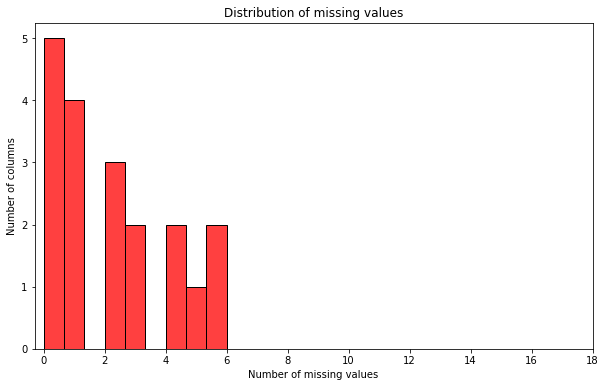

In [16]:
# Visualize number of missing values vs. number of columns 

num_missing = []
for col in df.columns:
    num_missing.append(df[col].isnull().sum())


plt.figure(figsize=(10, 6))
sns.histplot(num_missing, bins=9, color='r')
plt.title("Distribution of missing values")
plt.xlabel("Number of missing values")
plt.ylabel("Number of columns")
plt.xticks(range(0, 20, 2))
plt.show()

In [17]:
# Checking how many rows have null values to see if dropping them will have a significant impact on the data

df.T.isnull().any().sum()

print("Total number of rows in the dataset: {}\n".format(df.shape[0]))
print("Number of rows with null values: {}".format(df.shape[0] - df.dropna().shape[0]))

Total number of rows in the dataset: 846

Number of rows with null values: 33


<span style="color:maroon">**Observations:**
* `If we drop all the rows with any number of missing values, we end up with 813 rows, a drop by 33`
* `That means we keep about 96.1% of the rows, which still retains almost all the information... let's go ahead and drop the rows with missing values`

In [18]:
# Dropping the rows with missing values
df.dropna(inplace=True)

In [19]:
# Let's validate that we don't have any more missing values
df.isnull().any().any()

False

<span style="color:maroon">**Observation:**
* `We have handled the missing values`

## <span style="color:purple"> Univariate Analysis

In [20]:
# Target variable distribution
df["class"].value_counts()

car    413
bus    205
van    195
Name: class, dtype: int64

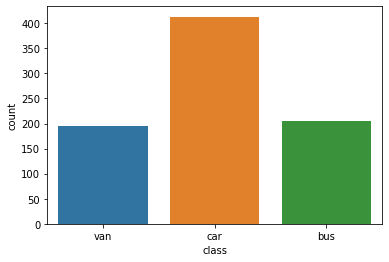

In [21]:
# Let's Visualize!
sns.countplot(x=df["class"])
plt.show()

<span style="color:maroon">**Observations:**
* `Out of the 813 total vehicles, 413 (50.8%) are cars, 205 (25.2%) are buses, and 195 (24%) are vans`
* `Car class is the most popular vehicle`

## <span style="color:purple"> Bivariate Analysis

In [22]:
# Pairplot to see influence of variables on value of target
# sns.pairplot(df, hue="class")
# plt.show()

In [23]:
# Few variables clearly have a very high correlation
# Due to too many features, it is hard to read. I will use correlation matrix to understand:
        # Correlation between independent variables
        # Correlation between target and independent variables

In [24]:
# Just for analysis, substituting class to numeric values
# This will allow us to understand correlation between target and independent variables
df_a = df.replace({"car":1, "bus":2, "van":3})

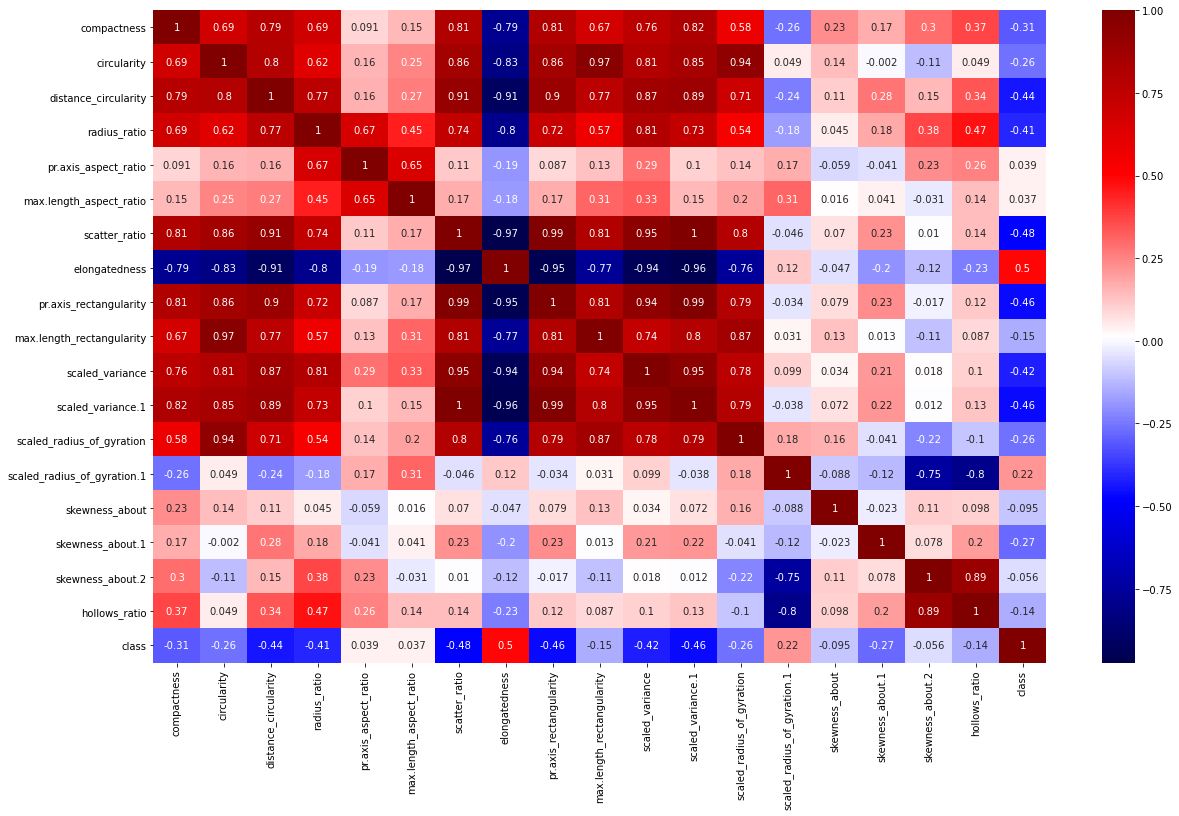

In [25]:
plt.figure(figsize=(20,12))
df_corr = df_a.corr()
sns.heatmap(df_corr, annot=True, fmt='.2g', cmap="seismic")
plt.show()

In [26]:
# The correlation matrix clearly indicates high correlation between few independent variables. For example:
                # pr.axis_rectangularity with scatter_ratio
                # scaled_variance.1 with pr.axis_rectangularity
# The correlation matrix also indicates features having very low correlation with target variable. For exaple:
                # max.length_aspect_ratio

# Instead of reviewing every cell visually, I will filter such high and low correlations
# I will set a threshold for high correlation => 0.95
# I will set a threshold for low correlation => 0.05

# If the |correlation| between 2 independent variables > high threshold, I will drop one
# If the |correlation| between target and independent variable < low threshold, I will drop the independent variable

In [27]:
# Saving dataset before feature engineering based on correlation, as df_orig. 
# I will try PCA on dataset copies with & without correlation based feature engineering 
df_orig = df.copy()

In [28]:
print("Number of columns in the original dataset: ", df.shape[1])

Number of columns in the original dataset:  19


In [29]:
for col in df.drop("class", axis=1).columns:
  try:
    for column in df.drop([col, "class"], axis=1).columns:
      try:
        if df[col].corr(df[column]) > 0.95 or df[col].corr(df[column]) < -0.95:
          print("Independent features with high correlation -> {}: {}".format(col, column))
          df.drop(column, axis=1, inplace=True)
      except:
        pass
  except:
    pass

Independent features with high correlation -> circularity: max.length_rectangularity
Independent features with high correlation -> scatter_ratio: elongatedness
Independent features with high correlation -> scatter_ratio: pr.axis_rectangularity
Independent features with high correlation -> scatter_ratio: scaled_variance
Independent features with high correlation -> scatter_ratio: scaled_variance.1


In [30]:
# Based on above comments, dropping independent variables based on low correlation with target

for col in df_a.drop("class", axis=1).columns:
    if df_a[col].corr(df_a["class"]) <= 0.05 and df_a[col].corr(df_a["class"]) >= -0.05:
        print("Independent feature with very low correlation with target: {}".format(col))
        df.drop(col, axis=1, inplace=True)

Independent feature with very low correlation with target: pr.axis_aspect_ratio
Independent feature with very low correlation with target: max.length_aspect_ratio


In [31]:
print("Number of columns after dropping based on high/low correlations: ", df.shape[1])

Number of columns after dropping based on high/low correlations:  12


In [32]:
# We have addressed:
    # Data quality issues
    # Missing values
    # Highly correlated independent variables
    # Features with very low correlation with target
    
# The data is now ready to be fed into the model for predictions!!!

# <span style="color:green"> ----------------------------------MODEL BUILDING-----------------------------

In [33]:
# Creating a empty summary dataframe, I will use this dataframe to capture performance measures

perf_summary_df = pd.DataFrame(columns=["Model Name", "Training Accuracy", "Testing Accuracy", "Cross Validation Accuracy"])

In [34]:
# Let's set values for variables we will be using while building models
# We will use variables instead on hardcoded value as best practice, as outlined below

seed = 7 # will use this for random_state, to ensure we are using same value for repeatable results
cv_folds = 3 # Number of folds while applying cross validation
test_size = 0.3 # Test dataset ratio

### <span style="color:blue"> Splitting the data into training and testing datasets

In [35]:
X = df.drop("class", axis=1)
y = df["class"]

In [36]:
# Let's scale the X data, to remove any bias.
X = X.apply(zscore)

In [37]:
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### <span style="color:blue"> Support Vector Machine model

In [38]:
# Initializing the Support Vector Machine Classifier model
svmc = SVC(random_state=seed)

In [39]:
# Fitting/Training the model on training dataset
svmc.fit(X_train , y_train)

SVC(random_state=7)

---------------ACCURACY SCORE WITH CROSS VALIDATION-----------------------


Model Type:  SVC(random_state=7)

Accuracy (with cross validation):
0.8857421331105542

-------------------ACCURACY SCORE WITHOUT CROSS VALIDATION---------------------------


Accuracy for train set: 0.947
Accuracy for test set: 0.910

              precision    recall  f1-score   support

         bus       0.98      0.90      0.94        63
         car       0.94      0.91      0.92       129
         van       0.77      0.92      0.84        52

    accuracy                           0.91       244
   macro avg       0.90      0.91      0.90       244
weighted avg       0.92      0.91      0.91       244



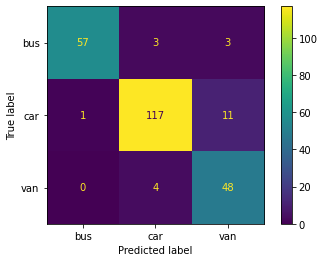

In [40]:
# Calling the custom function to score the model
perf_summary_df = score_model(perf_summary_df, X_train, X_test, y_train, y_test, svmc, "SVM WITHOUT PCA", 
            num_folds=cv_folds, seed=seed)

## <span style="color:blue"> PCA
    
As explained in earlier steps, I will try PCA on dataset:
    - before correlation based feature engineering 
    - after correlation based feature engineering

In [41]:
# first applying PCA to correlation based feature engineered dataset

In [42]:
# Initiziling our PCA model
pca = PCA(n_components=8)

In [43]:
# Fitting the PCA on the scaled data
pca.fit(X)

PCA(n_components=8)

In [44]:
# Explained variance for every new Principal Component
pca.explained_variance_ratio_

array([0.45213892, 0.25595836, 0.099738  , 0.08341101, 0.0405599 ,
       0.02746636, 0.01697196, 0.00904401])

In [45]:
# Coefficients for the Principal Components
pca.components_

array([[-0.39563923, -0.3847651 , -0.42294556, -0.38019714, -0.41634293,
        -0.34469606,  0.11749944, -0.08424925, -0.09834275, -0.11988226,
        -0.18678515],
       [-0.03560545,  0.23735597,  0.03034517, -0.06933582,  0.1495906 ,
         0.3109239 ,  0.49874743, -0.03599891, -0.10710762, -0.53733966,
        -0.51707274],
       [ 0.06823882,  0.11145162, -0.11558667, -0.09813711, -0.11631702,
         0.14518811, -0.07455658,  0.67198167, -0.67532557,  0.10926675,
         0.01413171],
       [ 0.06062024, -0.10290687,  0.026535  , -0.14971502, -0.0038288 ,
        -0.07421048,  0.06324129,  0.70294942,  0.66230033, -0.1217391 ,
        -0.0741305 ],
       [ 0.0187678 , -0.2021373 , -0.14798616,  0.63820794, -0.0595986 ,
        -0.16321225,  0.64625503,  0.11794564, -0.03579334,  0.25148987,
         0.05747805],
       [ 0.77628113, -0.26345042, -0.00458486, -0.19270738,  0.19559085,
        -0.4015852 ,  0.035259  , -0.08039858, -0.14776118, -0.01484828,
        -0.248

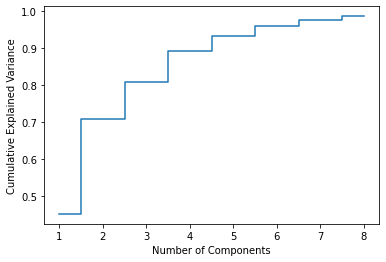

In [46]:
# Printing the graph for cumulative explained variance with every new Principal Component
plt.step(list(range(1, 9)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.show()

<span style="color:maroon">**OBSERVATIONS:**
* `We can see that around 95% of the data is explained with 6 principal components`
* `We are asked to use the number of components the explain ~95% of the data, so we can use 0.95 as the parameter instead of number of components`

In [47]:
# Initilizing the PCA with 95% explained variance

# We can pass 6 as the parameter based on above plot OR we can pass 0.95 explained variance.
# I want to try passing desired explained variance 0.95 as the parameter
# Later we will validate it actually uses 6 components

pca95 = PCA(0.95) 

# Fit and transdform the data with Principal Components
pca95.fit(X)
Xpca95 = pca95.transform(X)

In [48]:
# Printing out the total explained variance
expl_var_rat = pca95.explained_variance_ratio_
print(f"Total variance explained by {len(expl_var_rat)} Principal Components is: \n{round(sum(expl_var_rat), 4)*100}%")

Total variance explained by 6 Principal Components is: 
95.93%


In [49]:
# Checking the dataset after dimensionality reduction with PCA
Xpca95

array([[-0.47429606,  0.05196276, -0.20457586,  0.09840599, -0.27976067,
        -0.31999067],
       [ 0.90206826, -0.61096347,  0.24558461,  0.65157229, -0.2657675 ,
        -0.01735812],
       [-2.95748317,  0.82888451,  1.25948026,  0.58318716,  0.29766294,
         0.10802897],
       ...,
       [-3.20323506,  0.49176054,  0.10200199, -1.49027752,  0.03321675,
         0.47247877],
       [ 1.86302391, -1.23832744, -1.84520309,  0.19054601, -0.65475353,
        -0.19169684],
       [ 3.2378064 , -0.19792616, -1.20596122,  0.11809515, -0.41337393,
         0.28195401]])

In [50]:
# The data is really messy, let's convert it into a dataframe to organize it
Xpca = pd.DataFrame(Xpca95)
Xpca.head()

,0,1,2,3,4,5
0,-0.474296,0.051963,-0.204576,0.098406,-0.279761,-0.319991
1,0.902068,-0.610963,0.245585,0.651572,-0.265768,-0.017358
2,-2.957483,0.828885,1.259480,0.583187,0.297663,0.108029
3,0.606407,-2.945515,0.278229,-0.425547,-0.098141,0.204627
4,1.811356,5.273300,-0.211545,0.760846,5.094441,-0.580197


In [51]:
# Checking how many Principal Components we used
pca95.n_components_

6

As expected and explained above, the PCA model is using 6  pricipal components to explain 95% of the data

### <span style="color:blue"> Support Vector Machine with PCA
    
    On correlation based features engineered dataset

In [52]:
# Splitting the data into training and testing
X_train , X_test, y_train, y_test = train_test_split(Xpca, y, test_size=test_size, random_state=seed)

In [53]:
# Initializing the Support Vector Machine
svmc = SVC()

In [54]:
# Training the model
svmc.fit(X_train, y_train)

SVC()

---------------ACCURACY SCORE WITH CROSS VALIDATION-----------------------


Model Type:  SVC()

Accuracy (with cross validation):
0.7662768031189083

-------------------ACCURACY SCORE WITHOUT CROSS VALIDATION---------------------------


Accuracy for train set: 0.833
Accuracy for test set: 0.779

              precision    recall  f1-score   support

         bus       0.89      0.67      0.76        63
         car       0.84      0.81      0.83       129
         van       0.60      0.83      0.69        52

    accuracy                           0.78       244
   macro avg       0.78      0.77      0.76       244
weighted avg       0.80      0.78      0.78       244



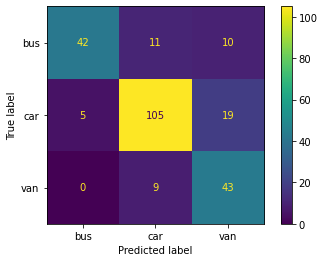

In [55]:
# Calling the custom function to score the model
perf_summary_df = score_model(perf_summary_df, X_train, X_test, y_train, y_test, svmc, "SVM WITH PCA", 
            num_folds=cv_folds, seed=seed)


#### <span style="color:red">Performance Comparison Report</span>

In [56]:
# Performance of SVM model with and without PCA
perf_summary_df

,Model Name,Training Accuracy,Testing Accuracy,Cross Validation Accuracy
0,SVM WITHOUT PCA,0.947,0.910,0.885742
1,SVM WITH PCA,0.833,0.779,0.766277


<span style="color:maroon">**OBSERVATIONS:**
* `The model performed BETTER  when we applied PCA rather than using the original data`
* `But, with PCA, our model seems to be overfitting the data, the difference between in sample and out of sample accuracy is over 6%!`

In [57]:
# Let's try PCA on orignal dataset (without correlation based features engineering)

In [58]:
# Prepare

X = df_orig.drop("class", axis=1)
y = df["class"]

# Let's scale the X data, to remove any bias.
X = X.apply(zscore)

In [59]:
# Apply PCA 
# I have given detailed explanation in earlier steps, here just writing python code

pca95 = PCA(0.95) # initialize
pca95.fit(X) # fit
Xpca95 = pca95.transform(X) # transform

# Printing out the total explained variance
expl_var_rat = pca95.explained_variance_ratio_
print(f"Total variance explained by {len(expl_var_rat)} Principal Components is: \n{round(sum(expl_var_rat), 4)*100}%")


Total variance explained by 7 Principal Components is: 
96.28%


In [60]:
# Let's convert it into a dataframe to organize it
Xpca = pd.DataFrame(Xpca95)

### <span style="color:blue"> Support Vector Machine with PCA
    
    Using orignal dataset (without correlation based features engineering)

In [61]:
# Splitting the data into training and testing
X_train , X_test, y_train, y_test = train_test_split(Xpca, y, test_size=test_size, random_state=seed)

In [62]:
# Initializing the Support Vector Machine
svmc = SVC()

In [63]:
# Training the model
svmc.fit(X_train, y_train)

SVC()

---------------ACCURACY SCORE WITH CROSS VALIDATION-----------------------


Model Type:  SVC()

Accuracy (with cross validation):
0.894541910331384

-------------------ACCURACY SCORE WITHOUT CROSS VALIDATION---------------------------


Accuracy for train set: 0.933
Accuracy for test set: 0.877

              precision    recall  f1-score   support

         bus       0.90      0.86      0.88        63
         car       0.91      0.86      0.88       129
         van       0.79      0.94      0.86        52

    accuracy                           0.88       244
   macro avg       0.87      0.89      0.87       244
weighted avg       0.88      0.88      0.88       244



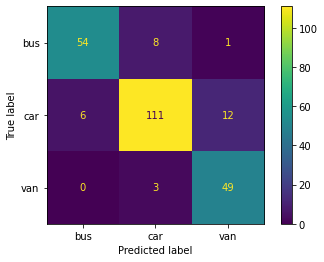

In [64]:
# Calling the custom function to score the model
perf_summary_df = score_model(perf_summary_df, X_train, X_test, y_train, y_test, svmc, "SVM WITH PCA (original data)", 
            num_folds=cv_folds, seed=seed)


In [65]:
perf_summary_df

,Model Name,Training Accuracy,Testing Accuracy,Cross Validation Accuracy
0,SVM WITHOUT PCA,0.947,0.910,0.885742
1,SVM WITH PCA,0.833,0.779,0.766277
2,SVM WITH PCA (original data),0.933,0.877,0.894542


## CONCLUSION:
* `The SVM without PCA seems to be the best performing model`
* `The SVM with PCA (on original data) has better cross validation score but seems to be overfit model`
